In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Dense
import argparse
import copy
import json
import os.path
from enum import Enum
from typing import Dict, Tuple, Union, Optional, Any
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from typing import List, Iterable, Optional, Union
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pandas as pd
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
from numpy import ndarray
from tensorflow import keras, Tensor
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.python.keras.models import Functional
from keras_models import generate_ncp_model

2025-05-06 08:24:14.075853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import numpy as np

In [5]:

base_dir = "dataset"
images_list = ["dataset/1/Image1.png", "dataset/1/Image50.png", 
               "dataset/1/Image100.png", "dataset/1/Image200.png", "dataset/1/Image833.png"]


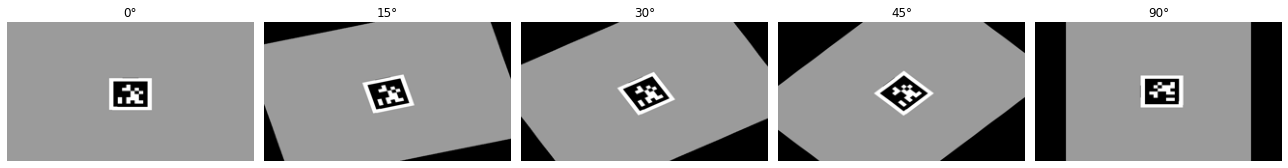

In [51]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# --- Rotation angles ---
rotation_angles = [0, 15, 30, 45, 90]

# --- Image path ---
image_path = "dataset/1/Image832.png"

# --- Tensor and image storage ---
processed_images = []
image_tensor_list = []
IMAGE_SHAPE_CV = (256, 144)  # width x height

# --- Process each rotated version ---
if os.path.exists(image_path):
    original_img = Image.open(image_path).convert("RGB")

    for angle in rotation_angles:
        # Rotate
        rotated_img = original_img.rotate(angle, resample=Image.BILINEAR)

        # Resize and convert to tensor
        rotated_img_resized = rotated_img.resize(IMAGE_SHAPE_CV)
        img_array = np.array(rotated_img_resized)
        img_array = np.expand_dims(img_array, axis=0)  # shape: (1, H, W, C)
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

        # Store results
        image_tensor_list.append(img_tensor)
        processed_images.append((f"{angle}°", rotated_img_resized))
else:
    print(f"Missing: {image_path}")

# --- Display all rotated images ---
if processed_images:
    fig, axes = plt.subplots(1, len(processed_images), figsize=(18, 5))
    for ax, (label, img) in zip(axes, processed_images):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No images to display.")


In [52]:
IMAGE_SHAPE = (144, 256, 3)
IMAGE_SHAPE_CV = (IMAGE_SHAPE[1], IMAGE_SHAPE[0])

DEFAULT_NCP_SEED = 22222

batch_size = None
seq_len = 64
augmentation_params = None
single_step = True
no_norm_layer = False
mymodel = generate_ncp_model(seq_len, IMAGE_SHAPE, augmentation_params, batch_size, DEFAULT_NCP_SEED, single_step, no_norm_layer)

# pretrained model weights
# mymodel.load_weights('model-ncp-val.hdf5')

# custom model weights
root = "./retrain_150traj_wscheduler0.85_seed22222_lr0.001_trainloss0.00035_valloss0.00019_coreset900.h5"
mymodel.load_weights(root)

conv_layers = [layer for layer in mymodel.layers if isinstance(layer, Conv2D)]

# Get the last Conv2D layer
last_conv = conv_layers[-1]

# Get the next two layers after the last Conv2D
layer_dict = {layer.name: layer for layer in mymodel.layers}
next_layer_1 = None
next_layer_2 = None

found = False
for i, layer in enumerate(mymodel.layers):
    if layer.name == last_conv.name:
        next_layer_1 = mymodel.layers[i + 1]
        next_layer_2 = mymodel.layers[i + 2]
        break

# Sanity check
assert isinstance(next_layer_1, Flatten), f"Expected Flatten, got {type(next_layer_1)}"
assert isinstance(next_layer_2, Dense), f"Expected Dense, got {type(next_layer_2)}"

# Create new visualization model
vis_model = Model(
    inputs=mymodel.inputs[0],
    outputs=[last_conv.output, next_layer_1.output, next_layer_2.output]
)

print(vis_model.summary())

base_dir = "dataset"
IMAGE_SHAPE = (144, 256, 3)
IMAGE_SHAPE_CV = (IMAGE_SHAPE[1], IMAGE_SHAPE[0])


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 144, 256, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 144, 256, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 144, 256, 3)       7         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 70, 126, 24)       1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 33, 61, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 29, 48)        43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 27, 64)        2771

In [59]:
latent_space_data_perturbed = []


for img_tensor in image_tensor_list:
    output = vis_model.predict([img_tensor])  # img_tensor shape: (1, 144, 256, 3)
    latent_vector = output[2]  # assuming this is shape (1, latent_dim)
    latent_space_data_perturbed.append(latent_vector.squeeze())  # flatten to 1D


In [60]:
latent_df_perturbed = pd.DataFrame(latent_space_data_perturbed, columns=[f"Z{i}" for i in range(latent_space_data_perturbed[0].shape[0])])


In [62]:
import pandas as pd
import numpy as np

# Step 1: Load original latent space and extract row 832
latent_df = pd.read_csv("./latent_space_output.csv")
original_latent_vector = latent_df.iloc[832]  # Series with index: Z0, Z1, ..., Zn

# Step 2: Stack all 5 perturbed latent vectors into a DataFrame
perturbed_df = pd.DataFrame(latent_space_data_perturbed, columns=latent_df.columns)

# Step 3: Compute absolute differences with original
abs_diff_df = (perturbed_df - original_latent_vector).abs()

# Step 4: Apply threshold to detect significant change
threshold = 0.5
changed_flags = abs_diff_df > threshold  # Boolean DataFrame

# Step 5: Find common columns where all rows are True
common_changed_columns = changed_flags.columns[changed_flags.all(axis=0)].tolist()

# Step 6: Output results
print("Commonly changed latent variables across all 5 rotations:")
print(common_changed_columns)


Commonly changed latent variables across all 5 rotations:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '64', '65', '66', '67', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127']


In [56]:
latent_df = pd.read_csv("./latent_space_output.csv")

# Indices to extract
row_indices = [832]

# Extract the rows
original_latents_subset = latent_df.iloc[row_indices]

# Reset index if needed
original_latents_subset.reset_index(drop=True, inplace=True)

L2 difference per sample (perturbed vs original):
Row 1: 277.9804
Row 50: 1001.1575
Row 100: 1828.3000
Row 200: 2014.8989
Row 832: 2689.2145


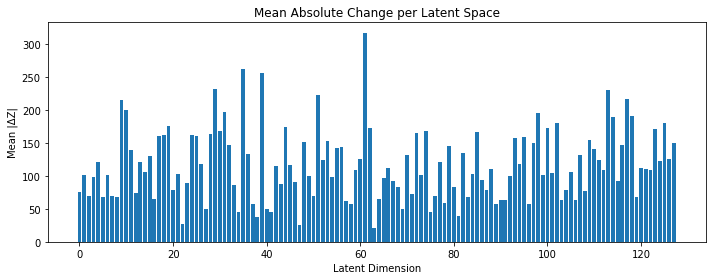

In [36]:
abs_diff = np.abs(latent_df_perturbed.values - original_latents_subset.values)

# --- 2. L2 norm per sample ---
l2_diff = np.linalg.norm(latent_df_perturbed.values - original_latents_subset.values, axis=1)

# --- 3. Mean difference per latent dimension ---
mean_change_per_latent = np.mean(abs_diff, axis=0)

# --- Print Results ---
print("L2 difference per sample (perturbed vs original):")
for i, l2 in zip(row_indices, l2_diff):
    print(f"Row {i}: {l2:.4f}")

# --- Plot mean absolute change per dimension ---
plt.figure(figsize=(10, 4))
plt.bar(range(len(mean_change_per_latent)), mean_change_per_latent)
plt.title("Mean Absolute Change per Latent Space")
plt.xlabel("Latent Dimension")
plt.ylabel("Mean |ΔZ|")
plt.tight_layout()
plt.show()

In [38]:
latent_indices = [
    34, 43, 59, 60, 73, 75, 80, 81, 84, 86,
    99, 100, 116, 120, 125, 127, 20, 27, 30, 50
]


In [46]:
original_selected = original_latents_subset[[f"{i}" for i in latent_indices]].to_numpy()
perturbed_selected = latent_df_perturbed[[f"Z{i}" for i in latent_indices]].to_numpy()

# Step 2: Compute absolute difference
abs_diff = np.abs(original_selected - perturbed_selected)

# Step 3: Threshold to flag significant changes
threshold = 0.05  # You can adjust this
changed_flags = abs_diff > threshold  # Boolean array: shape (5, len(latent_indices))

# Step 4: Report changes
for i, row_flags in enumerate(changed_flags):
    changed_vars = [latent_indices[j] for j, changed in enumerate(row_flags) if changed]
    print(f"Sample {i} (original row {row_indices[i]}): changed latent variables: {changed_vars}")

Sample 0 (original row 1): changed latent variables: [34, 43, 59, 60, 73, 75, 80, 81, 84, 86, 99, 100, 116, 120, 125, 127, 20, 27, 30, 50]
Sample 1 (original row 50): changed latent variables: [34, 43, 59, 60, 73, 75, 80, 81, 84, 86, 99, 100, 116, 120, 125, 127, 20, 27, 30, 50]
Sample 2 (original row 100): changed latent variables: [34, 43, 59, 60, 73, 75, 80, 81, 84, 86, 99, 100, 116, 120, 125, 127, 20, 27, 30, 50]
Sample 3 (original row 200): changed latent variables: [34, 43, 59, 60, 73, 75, 80, 81, 84, 86, 99, 100, 116, 120, 125, 127, 20, 27, 30, 50]
Sample 4 (original row 832): changed latent variables: [34, 43, 59, 60, 73, 75, 80, 81, 84, 86, 99, 100, 116, 120, 125, 127, 20, 27, 30, 50]
